# ENGG03 - Avaliação 02

* **Docente:** Raony Maia Fontes
* **Alunos:** Anna Carolina, Breno Conceição, Gustavo Santos Borges, Maurício Vicente

# Observações
Os códigos devem está comentados deixando claro para que serve cada função ou trecho de código usado.

Além disso, é importante explicitar o racionío por trás da construção da resposta, deixando evidente as justificativas para a escolha das funções, representações, simplificações, manipulações e etc, utilizadas.

# Questão 1

Um reator contínuo de tanque agitado, também chamado de CSTR (continuous stirred-tank reactor), é um tipo de reator ideal e comum em engenharia química e modelado através de balanços de massa e energia.

Dada uma reação A → B exotérmica realizada em um CSTR que possui uma camisa por onde passa um fluído refrigerante, através dos balanços de massa energia obtem-se a seguinte representação:
\begin{align}
\begin{cases}
\frac{dC_A(t)}{dt} = -k_0 \cdot C_A(t) \cdot e^{-E_R/T(t)} + \frac{Q_f(t) \cdot C_{Af} - Q(t)\cdot C_A(t)}{a \cdot h(t)} \\
\frac{dT(t)}{dt} = \frac{-k_0 \cdot C_A(t) \cdot \Delta H \cdot e^{-E_R/T(t)}}{\rho C_p} + \frac{Q_f(t) \cdot T_f - Q(t)\cdot T(t)}{a \cdot h(t)} + \frac{U_{a_c} \cdot (T_c(t) - T(t))}{\rho C_p \cdot a \cdot h(t)} \\
\frac{dT_c(t)}{dt} = \frac{Q_c \cdot (T_{cf} - T_c(t))}{V_c} + \frac{U_{a_c} \cdot (T(t) - T_c(t))}{\rho C_{pc} \cdot V_c} \\
\frac{dh(t)}{dt} = \frac{Q_f(t) - Q(t)}{a}
\end{cases}
\end{align}

onde: $a$ = 0.1666 m$^2$, $V_c$ = 0.01 m$^3$, $U_{a_c}$ = 5$\times$10$^4$ J/(min$\cdot$K), $\rho C_p$ = 2.39$\times$10$^5$ J/(m$^3 \cdot $K), $\rho C_{pc}$ = 4.175$\times$10$^6$ J/(m$^3 \cdot $K) \), $k_0$ = 7.2$\times$10$^{10}$ min$^{-1}$, $E_R$ = 8750 K, $\Delta H$ = -5$\times$10$^4$ J/mol, $Q(t)$ = 0.1 m$^3$/min, $C_{Af}$ = 1000 mol/m$^3$, $T_f$ = 320 K, $Q_c$ = 0.015 m$^3$/min, $T_{cf}$ = 300 K, $0 \leq h(t) \leq 2.0$m

#### Importação de bibliotecas

O primeiro passo para a devida execução do programa é a importação das bibliotecas necessárias para atingir os objetivos propostos. Entre elas, é possível citar:

*   `numpy`: Biblioteca que permite a manipulação de dados em arranjos, vetores, matrizes multi-dimensionais e operações matemáticas;
*   `scipy`: Biblioteca que também permite empregar operações matemáticas ao código, porém, incorpora de forma acessível operadores e métodos mais complexos, tais quais a `solve_ivp`, função utilizada para resolução de equações diferenciais, e a `fsolve`, função com a qual é possível encontrar as raízes de funções quaisquer e, dessa forma, viabiliza a resolução de sistemas de equações não-lineares;
*   `matplotlib`: Biblioteca utilizada para plotagem de gráficos ilustrando os dados e resultados de processamentos feitos no programa.

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

#### Definição de constantes

Em seguida, as constantes do sistema fornecidas no enunciado serão definidas no programa, para que sejam inseridas em seus respectivos contextos, sendo essas:



*   `a`: Área da seção transversal do reator, em m² ($a$)
*   `Vc`: Volume da camisa de resfriamento, em m³ ($V_c$)
*   `Uac`: Coeficiente global de transferência de calor, em J/(min*K) ($U_{a_c}$)
*   `rhoCp`: Capacidade térmica volumétrica do fluido reacional, em J/(m³*K) ($\rho C_p$)
*   `rhoCpc`: Capacidade térmica volumétrica do fluido de resfriamento, em J/(m³*K) ($\rho C_{pc}$)
*   `k0`: Constante da taxa de reação, em min$^{-1}$ ($k_0$)
*   `ER`: Energia de ativação, em K ($E_R$)
*   `DeltaH`: Variação de entalpia da reação, em J/mol ($\Delta H$)
*   `Q0`: Vazão de alimentação no momento inicial, em m³/min ($Q(0)$)
*   `Caf`: Concentração do reativo na alimentação, em mol/m³ ($C_{Af}$)
*   `Tf`: Temperatura da alimentação, em K ($T_f$)
*   `Qc`: Vazão de resfriamento, em m³/min ($Q_c$)
*   `Tcf`: Temperatura da camisa de resfriamento, em K ($T_{cf}$)

In [ ]:
a = 0.1666
Vc = 0.01
Uac = 5e4
rhoCp = 2.39e5
rhoCpc = 4.175e6
k0 = 7.2e10
ER = 8750
DeltaH = -5e4
Q0 = 0.1
Caf = 1000
Tf = 320
Qc = 0.015
Tcf = 300

#### Definição do sistema de EDOs

As modelagens que serão propostas ao longo do presente trabalho dependerão da resolução do sistema de equações diferenciais ordinárias apresentado no enunciado principal. Simulações como o comportamento da planta no estado estacionário e implementação de controle em malha fechada dependerão da manipulação de dados numéricos de entrada emulados através do tempo.

Essa manipulação será possível através da definição da função `edos`, que receberá os seguintes parâmetros:

*   `t`: Instante ou intervalo no qual o sistema deverá ser simulado
*   `y`: Vetor contendo os valores das variáveis variantes no tempo, estes podendo ser valores iniciais ou valores pressupostos
*   `Qf`: Degrau de entrada do sistema, na forma da vazão de alimentação $Q_f(t)$
*   `Qf`: Valor da vazão inicial do sistema

A resolução das equações diferenciais a compor o sistema serão expressas através das seguintes variáveis:

*   `dCadt`: Equação descrevendo a variação da concentração de A no tempo ($\frac{dC_A(t)}{dt}$)
*   `dTdt`: Equação descrevendo a variação da temperatura do reator no tempo ($\frac{dT(t)}{dt}$)
*   `dTcdt`: Equação descrevendo a variação da temperatura da camisa no tempo ($\frac{dT_c(t)}{dt}$)
*   `dhdt`: Equação descrevendo a variação do nível do reator no tempo ($\frac{dh(t)}{dt}$)

Dadas as entradas, a função `edos` retornará um novo vetor contendo os resultados das equações a compor o sistema:

In [ ]:
def edos(t, y, Qf, Q):
  Ca, T, Tc, h = y

  dCadt = -k0 * Ca * np.exp(-ER / T) + (Qf * Caf - Q * Ca) / (a * h)

  dTdt = (-k0 * Ca * DeltaH * np.exp(-ER / T) / rhoCp +
            (Qf * Tf - Q * T) / (a * h) +
            Uac * (Tc - T) / (rhoCp * a * h))

  dTcdt = Qc * (Tcf - Tc) / Vc + Uac * (T - Tc) / (rhoCpc * Vc)

  dhdt = (Qf - Q) / a

  return [dCadt, dTdt, dTcdt, dhdt]

Realizados os passos descritos anteriormente, encontram-se dispostos todos os artifícios necessários para virtualizar o sistema proposto e, assim, executar as simulações.

## Item 1.1

Avalie o estacionário do sistema para um valor de vazão de alimientação $Q_f(0) = 0.1$ m$^3$/min e $h(0)$ = 1.0 m. Em seguida, simule o comportamento do reator no intervalo de 0 ≤ t ≤ 50 min, aplicando um degrau na vazão de alimentação
$Q_f(t) = \begin{cases}
0.1 & t < 5 \text{ min} \\
0.11 & t \geq 5 \text{ min}
\end{cases}$,
sabendo que o sistema parte do estado estacionário.

Apresente os gráficos de concentração do reagente $C_A(t)$, temperatura interna do reator $T(t)$, temperatura da camisa $T_c(t)$ e nível no interior do CSTR $h(t)$ e discuta os resultados

#### Definição da função degrau

Como citado no enunciado, será aplicado um degrau na vazão de alimentação na forma de $Q_f(t)$. Obedecendo às condições que serão abordadas futuramente, nas quais, após 5min, a vazão de alimentação muda para 0,11 m³/min, define-se o degrau como `Qf`, tendo como parâmetro o instante `t`, em minutos:

In [ ]:
def funcao_Qf(t):
    return 0.11 if t >= 5 else 0.1

#### Definição das variáveis em estado estacionário

Haja vista que a análise proposta parte do estado estacionário do sistema, é necessário que sejam definidas as condições estacionárias - isto é, os valores das grandezas variantes no tempo no instante inicial $t_0$.

Isso será possível através da função `cond_estacionarias`, que nada mais é do que uma referência à função `edos`, considerando `t` unicamente como sendo igual a 0 - analisando, assim, apenas a resolução do sistema de equações diferenciais em um ponto - e a vazão de entrada nesse momento como sendo igual à vazão inicial $Q_0$.

Dito isso, será possível usar a `fsolve`, importada no início do programa, para encontrar as resoluções mais adequadas para a função `cond_estacionarias`, utilizando como base valores iniciais hipotéticos para dedução dos valores objetivados, levando em consideração que, dado o fato de a análise estar sendo feita sobre o estado estacionário, as derivadas serão iguais a zero, e o conjunto de valores descritos até então corresponde às raízes das equações trabalhadas:

In [ ]:
def cond_estacionarias(y):
  return edos(0, y, Q0, Q0)

hipotese_inicial = [700, 300, 300, 0.8]

estado_estacionario = fsolve(cond_estacionarias, hipotese_inicial)
Ca0, T0, Tc0, h0 = estado_estacionario

print(f"Condições estacionárias encontradas:")
print(f"Concentração de A: {Ca0:.2f} mol/m³")
print(f"Temperatura do reator: {T0:.2f} K")
print(f"Temperatura da camisa: {Tc0:.2f} K")
print(f"Nível do reator: {h0:.2f} m")

Condições estacionárias encontradas:
Concentração de A: 871.65 mol/m³
Temperatura do reator: 321.66 K
Temperatura da camisa: 309.61 K
Nível do reator: 0.80 m


#### Teste de erro com as raízes

Sendo a variável `estado_estacionario` um vetor contendo as condições estacionárias, presume-se que, caso sejam inseridos como entradas na função `cond_estacionarias`, os resultados tenderão a zero, corroborando com a ideia de que essas descrevem o estado no qual o sistema encontra-se em repouso. Quanto menores os valores de saída forem, mais preciso é o valor das condições iniciais:

In [ ]:
erros = cond_estacionarias(estado_estacionario)
print(f"Erros das condições estacionárias: {erros}")

Erros das condições estacionárias: [-5.417177817435004e-11, 1.1361578344804002e-11, -1.5987211554602254e-14, 0.0]


Sendo os erros na estimativa das condições estacionárias conhecidos, torna-se possível definir se estão dentro do intervalo de tolerância considerado adequado para simulação confiável do sistema. Para tal, foi estimada uma tolerância de 1$\times$10$^{-6}$ e, caso algum dos valores de erro descritos no vetor possua módulo maior que esse limite, estes serão ajustados pela função `ajuste_ivp`, na qual serão feitos novos testes utilizando novas estimativas iniciais para as variáveis:

In [ ]:
def ajuste_ivp(estimativa_inicial, tolerancia=1e-6, tentativas=100):
  for i in range(tentativas):
    estado_estacionario = fsolve(cond_estacionarias, estimativa_inicial)
    erros = cond_estacionarias(estado_estacionario)
    if np.all(np.abs(erros) < tolerancia):
      return estado_estacionario
    estimativa_inicial = estado_estacionario
  raise ValueError("Não foi possível encontrar as condições iniciais com erro suficiente")

if np.any(np.abs(erros) > 1e-6):
  estado_estacionario = ajuste_ivp(hipotese_inicial)
  Ca0, T0, Tc0, h0 = estado_estacionario
  print(f"Condições iniciais ajustadas:")
  print(f"Concentração de A: {Ca0:.2f} mol/m³")
  print(f"Temperatura do reator: {T0:.2f} K")
  print(f"Temperatura da camisa: {Tc0:.2f} K")
  print(f"Nível do reator: {h0:.2f} m")
  erros = cond_estacionarias(estado_estacionario)
  print(f"Erros das condições ajustadas: {erros}")
else:
  print("As condições iniciais já estão dentro do intervalo de tolerância.")

As condições iniciais já estão dentro do intervalo de tolerância.


#### Simulação do sistema

Com as condições estacionárias sendo conhecidas, e tendo em mãos o sistema de equações diferenciais que descrevem o sistema, é possível realizar a simulação do sistema em malha aberta através da função `sem_controle`, na qual será definido um intervalo de tempo em minutos através de `t_span`, este, de acordo com o enunciado, sendo igual a 50min:

In [ ]:
def sem_controle():
  def vazao_t(t, y):
    Qf = funcao_Qf(t)
    return edos(t, y, Qf, Q0)

  t_span = [0, 50]
  y0 = estado_estacionario
  sol = solve_ivp(vazao_t, t_span, y0, t_eval=np.linspace(0, 50, 1000))
  return sol.t, sol.y

Por fim, os resultados da função `sem_controle` são armazenados em diferentes variáveis, que equivalem ao eixo do tempo - comum a todos os gráficos plotados - e o eixo representando cada uma das variáveis analisadas.

Quatro gráficos serão plotados, descrevendo o comportamento das grandezas trabalhadas em função do tempo, permitindo assim observar suas tendências em um sistema em malha aberta - tendo em mente que não foi, até então, implementado nenhum sistema ou estratégia de controle.

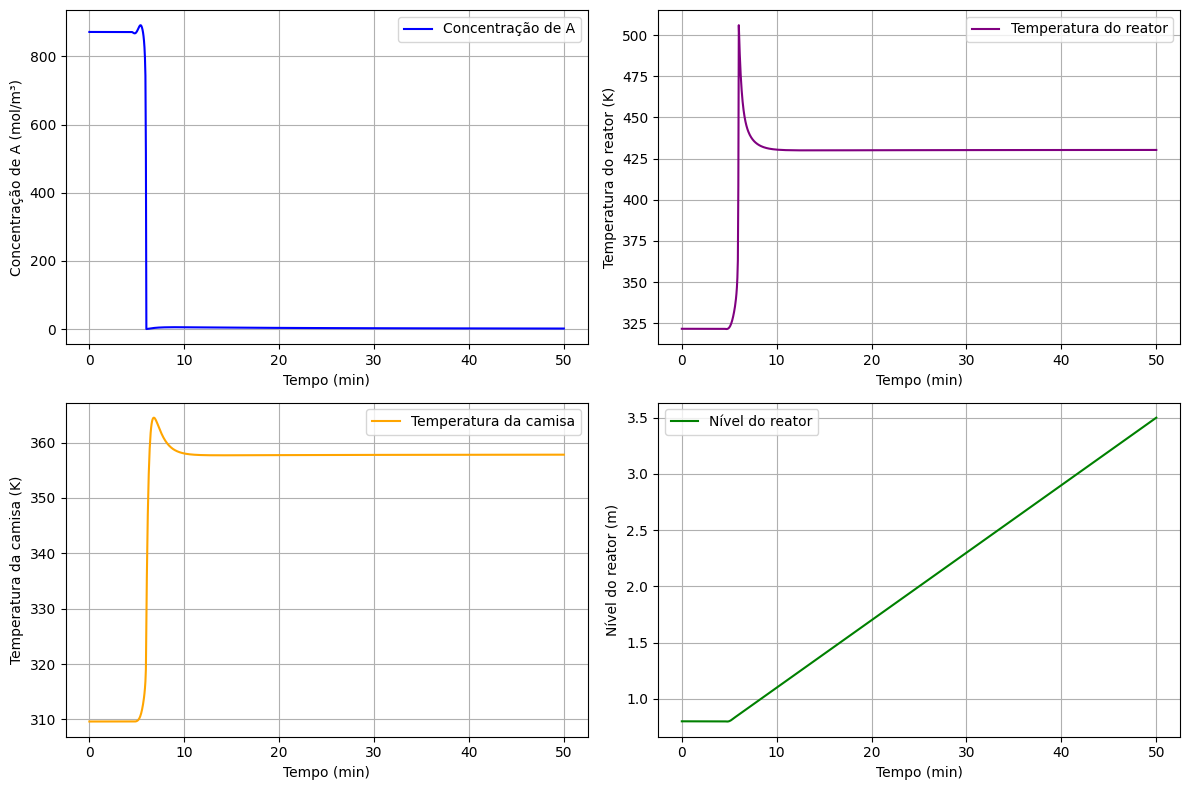

In [ ]:
t_sem_controle, y_sem_controle = sem_controle()

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_sem_controle, y_sem_controle[0, :], label='Concentração de A', color='blue')
plt.xlabel('Tempo (min)')
plt.ylabel('Concentração de A (mol/m³)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_sem_controle, y_sem_controle[1, :], label='Temperatura do reator', color='purple')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura do reator (K)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_sem_controle, y_sem_controle[2, :], label='Temperatura da camisa', color='orange')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura da camisa (K)')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(t_sem_controle, y_sem_controle[3, :], label='Nível do reator', color='green')
plt.xlabel('Tempo (min)')
plt.ylabel('Nível do reator (m)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Item 1.2

Para garantir melhor estabilidade do processo e evitar que o nível do tanque $(h(t))$ seque ou transborde é adicionado um controlador cujo o objetivo é manter o nível em um valor desejado (Sp = 1.0 m) manipulando a vazão de descarga $Q(t)$.

O Controlador em questão é o famoso proporcional-integral, representado pela seguinte equação:

\begin{align}
e(t) &= Sp - h(t)\\
Q(t) &= Q(0) + P\left(e(t) + I\int_0^{t} e(t) \right)
\end{align}
onde, $Q(0)$ = 0.1 m$^3$/min, $P$ = -1/6 m$^2$, $I$ = 1.0 min$^{-1}$

Simule o CSTR com o controlador de nível e apresente os gráficos de concentração do reagente $C_A(t)$, temperatura interna do reator $T(t)$, temperatura da camisa $T_c(t)$ e nível no interior do CSTR $h(t)$, comparando com os resultados encontrados no item anterior.

#### Definição da função com controle

A simulação solicitada no item acima exige que seja escrita uma nova função, a qual terá como base de funcionamento os mesmos parâmetros, porém, considerando que haverá manipulação da vazão através da implementação de um sistema de controle de nível, visando maior estabilidade e confiabilidade ao sistema.

Estabelecem-se aqui as seguintes variáveis:

*   `P`: Ganho proporcional do controlador, de acordo com as diretivas dadas no enunciado
*   `I`: Ganho integral do controlador, também de acordo com as diretivas dadas no enunciado
*   `Sp`: Setpoint do sistema, ponto de referência do nível do reator

A matriz `valores` armazena as soluções calculadas com a implementação de controle. Através do acúmulo de resultados que levam em consideração a correção feita pelo controlador projetado, é possível, a cada loop de execução, calcular o erro da variável, através da diferença entre o setpoint e o último valor de nível simulado.

Esse valor é, após o cálculo, armazenado na variável `erro`. Os índices utilizados na matriz `valores` equivalem, respectivamente, à iteração anterior da simulação do sistema (i-1) e o valor de nível dessa iteração (3, o que, computacionalmente, equivale à 4ª posição, que fora padronizada como sendo a posição em que foram armazenadas as leituras de nível)

In [ ]:
def com_controle():
  P = -1/6
  I = 1.0
  Sp = 1.0
  t_eval = np.linspace(0, 50, 1000)
  valores = np.zeros((len(t_eval), 4))
  valores[0] = estado_estacionario
  integral = 0

  def vazao_ajustada(t, y, Q):
    return edos(t, y, funcao_Qf(t), Q)

  for i in range(1, len(t_eval)):
    t_anterior = t_eval[i-1]
    t_atual = t_eval[i]

    erro = Sp - valores[i-1, 3]
    integral += erro * (t_atual - t_anterior)
    Q = Q0 + P * (erro + I * integral)

    sol = solve_ivp(lambda t, y: vazao_ajustada(t, y, Q), [t_anterior, t_atual], valores[i-1], t_eval=[t_atual])
    valores[i] = sol.y[:, -1]

  return t_eval, valores

Por fim, são plotados os gráficos comparando as curvas das variáveis do processo em malha aberta e malha fechada com controlador PI:

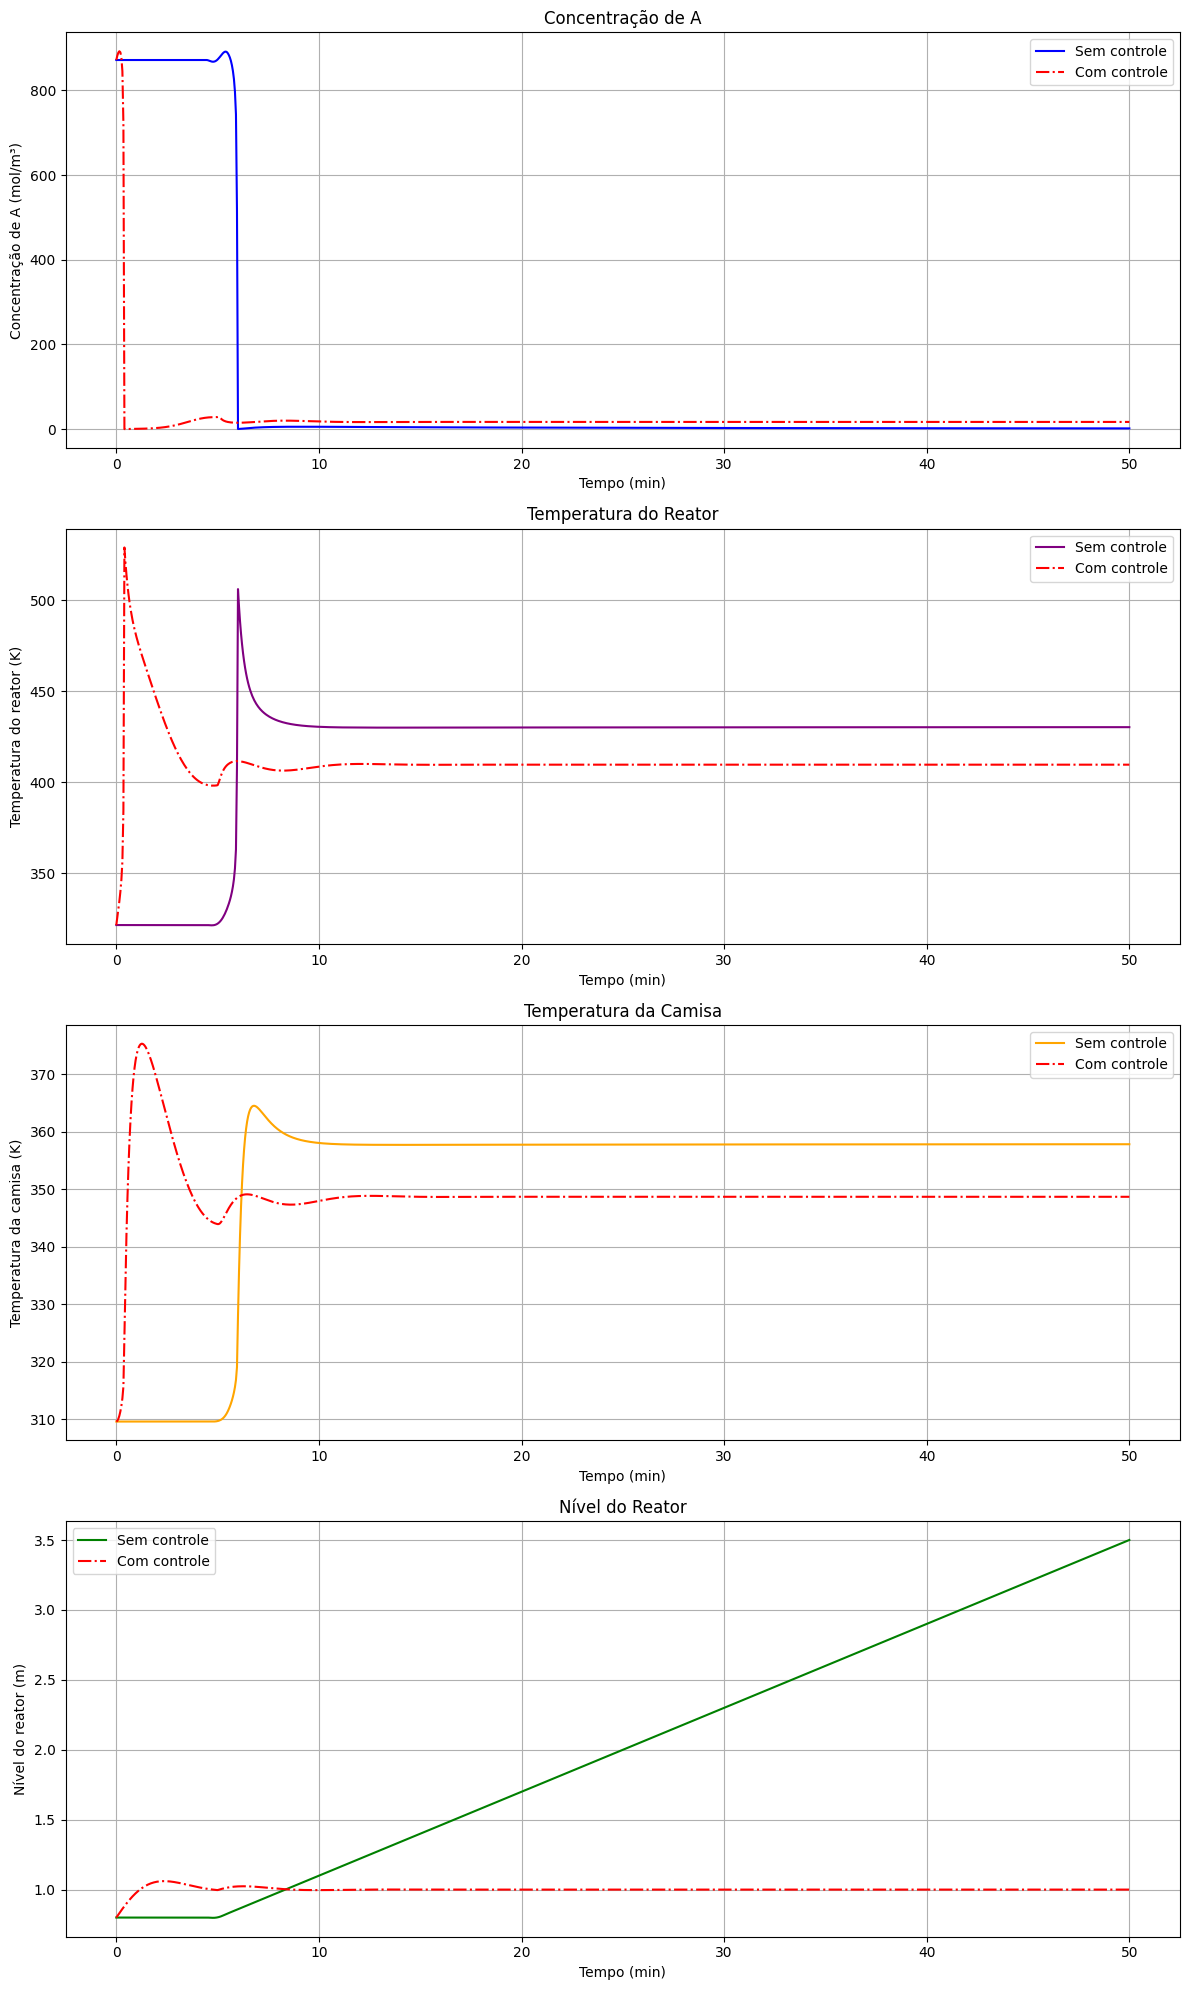

In [ ]:
t_sem_controle, y_sem_controle = sem_controle()
t_com_controle, y_com_controle = com_controle()

plt.figure(figsize=(12, 20))

plt.subplot(4, 1, 1)
plt.plot(t_sem_controle, y_sem_controle[0, :], label='Sem controle', color='blue')
plt.plot(t_com_controle, y_com_controle[:, 0], label='Com controle', color='red', linestyle='-.')
plt.xlabel('Tempo (min)')
plt.ylabel('Concentração de A (mol/m³)')
plt.title('Concentração de A')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t_sem_controle, y_sem_controle[1, :], label='Sem controle', color='purple')
plt.plot(t_com_controle, y_com_controle[:, 1], label='Com controle', color='red', linestyle='-.')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura do reator (K)')
plt.title('Temperatura do Reator')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t_sem_controle, y_sem_controle[2, :], label='Sem controle', color='orange')
plt.plot(t_com_controle, y_com_controle[:, 2], label='Com controle', color='red', linestyle='-.')
plt.xlabel('Tempo (min)')
plt.ylabel('Temperatura da camisa (K)')
plt.title('Temperatura da Camisa')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t_sem_controle, y_sem_controle[3, :], label='Sem controle', color='green')
plt.plot(t_com_controle, y_com_controle[:, 3], label='Com controle', color='red', linestyle='-.')
plt.xlabel('Tempo (min)')
plt.ylabel('Nível do reator (m)')
plt.title('Nível do Reator')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()